In [1]:
import nltk
from nltk.corpus import brown
from nltk.corpus import gutenberg

In [2]:
brown_untag = brown.sents()
guten = gutenberg.sents()

In [3]:
from sklearn.model_selection import train_test_split
br_untag_train, br_untag_test = train_test_split(list(brown_untag), test_size=0.2,random_state=1)
gt_train,gt_test = train_test_split(list(guten),test_size=0.2,random_state=1)

br_untag_dev, br_untag_test = train_test_split(br_untag_test, test_size=0.5,random_state=1)
gt_dev,gt_test = train_test_split(gt_test,test_size=0.5,random_state=1)

In [4]:
UNK = '<unk>'
START = '<s>'
STOP = '</s>'

def unigram(train):
    uni = []
    unks = set()
    for i in range(len(train)):
        sen = [w for w in train[i] if w not in [':','/',';','|',"''",'``','(',')','-','--','_','"',',']]
        sen.insert(0,START)  
        sen.insert(0,START)
        sen.append(STOP)
        uni += sen

    uni_cfd = nltk.FreqDist(uni)

    for word,freq in uni_cfd.items():
        if freq == 1:
            unks.add(word)

    for word in unks:
        del uni_cfd[word]

    uni_cfd[UNK] = len(unks)
    
    return unks,uni_cfd

In [5]:
def bi_and_tri(train,unks):
    bi = []
    tri_ls = []
    for i in range(len(train)):
        sen = [w if w not in unks else UNK for w in train[i] if w not in [':','/',';','|',"''",'``','(',')','-','--','_','"',',']]
        sen.insert(0,START)  
        sen.insert(0,START)
        sen.append(STOP)

        x = nltk.bigrams(sen)
        bi += list(x)

        x = nltk.trigrams(sen)
        tri_ls.append(list(x))

    tri = []

    for i in range(len(tri_ls)):
        l = [((a,b),c) for (a,b,c) in tri_ls[i]]
        tri += l

    bi_cfd = nltk.ConditionalFreqDist(bi)

    tri_cfd = nltk.ConditionalFreqDist(tri)
    
    return bi_cfd,tri_cfd

In [6]:
def test_data(test,uni_cfd):
    test_data = []
    for i in range(len(test)):
        sen = [w if uni_cfd[w]!=0 else UNK for w in test[i] if w not in [':','/',';','|',"''",'``','(',')','-','--','_','"']]
        sen.insert(0,START)  
        sen.insert(0,START)
        sen.append(STOP)
        test_data.append(sen)
        
    return test_data

In [8]:
import numpy as np

def calc_perp_backoff(uni_cfd,bi_cfd,tri_cfd,test):
    total_words=0
    prob=0
    uni_den = sum(uni_cfd.values()) - uni_cfd[START] - uni_cfd[STOP]
    for sen in test:
        if(len(sen)>3):
            w=(sen[0],sen[1])
            for word in sen[2:-1]:
                num = tri_cfd[w][word]
                if(num == 0):                    
                    num = bi_cfd[w[1]][word]
                    num=num
                    if(num == 0):
                        den=uni_den
                        num = uni_cfd[word]
                        num=num
                    else:
                        den = sum(bi_cfd[w[1]].values())
                else:
                    den = sum(tri_cfd[w].values())                    
                        
                p=num/den 
                prob+=np.log(p)
                w=(w[1],word)
                total_words+=1

    prob = (-1*prob)/total_words
    return np.exp(prob)

In [9]:
br_unks,br_uni_cfd = unigram(br_untag_train)

br_bi_cfd,br_tri_cfd = bi_and_tri(br_untag_train,br_unks)

br_test = test_data(br_untag_test,br_uni_cfd)

gt_unks,gt_uni_cfd = unigram(gt_train)

gt_bi_cfd,gt_tri_cfd = bi_and_tri(gt_train,gt_unks)

gt_test = test_data(gt_test,gt_uni_cfd)

In [50]:
# BROWN TRAIN AND BROWN TEST
br_perp1 = calc_perp_backoff(br_uni_cfd,br_bi_cfd,br_tri_cfd,br_test)
print(br_perp1)

194.9578058861574


In [51]:
# GUTENBERG TRAIN AND GUTENBERG TEST
gt_perp1 = calc_perp_backoff(gt_uni_cfd,gt_bi_cfd,gt_tri_cfd,gt_test)
print(gt_perp1)

125.73062672693864


In [10]:
# BROWN TRAIN + GUTENBERG TRAIN
comb_train = br_untag_train + gt_train
comb_test = br_untag_test + gt_test
comb_dev = br_untag_dev + gt_dev

comb_unks,comb_uni_cfd = unigram(comb_train)

comb_bi_cfd,comb_tri_cfd = bi_and_tri(comb_train,comb_unks)

comb_test = test_data(comb_test,comb_uni_cfd)

In [52]:
# COMBINE TRAIN & BROWN TEST
comb_perp_br1 = calc_perp_backoff(comb_uni_cfd,comb_bi_cfd,comb_tri_cfd,br_test)
print(comb_perp_br1)

243.87237380139763


In [56]:
# COMBINE TRAIN &  GUTENBERG TEST
comb_perp_gt1 = calc_perp_backoff(comb_uni_cfd,comb_bi_cfd,comb_tri_cfd,gt_test)
print(comb_perp_gt1)

131.91274723801297


## Interpolate

In [54]:
def find_hyper(uni_cfd,bi_cfd,tri_cfd,test):
    l = 0
    p = 10000 
    blam1=0.3
    blam2=0.3
    blam3=0.4
    for lam1 in [0.1,0.3,0.5]:
        for lam2 in [0.1,0.3,0.5]:
            l= 1-lam1-lam2
            if(l>0):
                perp = cal_perp_interpolate(uni_cfd,bi_cfd,tri_cfd,test,lam1,lam2,l)
                if(perp<p):
                    p=perp
                    blam1 = lam1
                    blam2 = lam2
                    blam3 = l
                    
    return blam1,blam2,blam3

In [30]:
def cal_perp_interpolate(uni_cfd,bi_cfd,tri_cfd,test,lam1,lam2,lam3):
    total_words=0
    prob=0
    uni_den = sum(uni_cfd.values()) - uni_cfd[START] - uni_cfd[STOP]
    for sen in test:
        if(len(sen)>3):
            w=(sen[0],sen[1])
            for word in sen[2:-1]:
                num_tri = tri_cfd[w][word]                    
                num_bi = bi_cfd[w[1]][word]
                num_uni = uni_cfd[word]
                
                den_tri = sum(bi_cfd[w[1]].values())
                den_bi = sum(tri_cfd[w].values())
                
                if(den_tri==0):
                    p1=0
                else:
                    p1=num_tri/den_tri
                if(den_bi==0):
                    p2=0
                else:
                    p2=num_bi/den_bi
                    
                p3=num_uni/uni_den
                p=lam1*(p1) + lam2*(p2) +lam3*(p3)
                
                prob+=np.log(p)
                w=(w[1],word)
                total_words+=1

    prob = (-1*prob)/total_words
    return np.exp(prob)

In [35]:
br_untag_dev = test_data(br_untag_dev,br_uni_cfd)
gt_dev = test_data(gt_dev,gt_uni_cfd)
comb_dev = test_data(comb_dev,comb_uni_cfd)

In [32]:
# BROWN TRAIN HYPERPARAMETER
lam1,lam2,lam3 = find_hyper(br_uni_cfd,br_bi_cfd,br_tri_cfd,br_untag_dev)
print(lam1,lam2,lam3)

0.1 0.5 0.4


In [33]:
# BROWN TRAIN AND BROWN TEST
br_perp = cal_perp_interpolate(br_uni_cfd,br_bi_cfd,br_tri_cfd,br_test,lam1,lam2,lam3)
print(br_perp)

68.59357867409265


In [44]:
#GUTENBERG TRAIN HYPERPARAMETER
lam1,lam2,lam3 = find_hyper(br_uni_cfd,br_bi_cfd,br_tri_cfd,gt_dev)
print(lam1,lam2,lam3)

0.3 0.3 0.4


In [40]:
# GUTENBERG TRAIN AND GUTENBERG TEST
gt_perp = cal_perp_interpolate(gt_uni_cfd,gt_bi_cfd,gt_tri_cfd,gt_test,lam1,lam2,lam3)
print(gt_perp)

30.418774718135257


In [45]:
#COMBINE TRAIN HYPERPARAMETER
lam1,lam2,lam3 = find_hyper(br_uni_cfd,br_bi_cfd,br_tri_cfd,comb_dev)
print(lam1,lam2,lam3)

0.3 0.3 0.4


In [47]:
# COMBINE TRAIN & BROWN TEST
comb_perp_br = cal_perp_interpolate(comb_uni_cfd,comb_bi_cfd,comb_tri_cfd,br_test,lam1,lam2,lam3)
print(comb_perp_br)

71.51242226238872


In [67]:
# COMBINE TRAIN & GUTENBERG TEST
comb_perp_gt = cal_perp_interpolate(comb_uni_cfd,comb_bi_cfd,comb_tri_cfd,gt_test,lam1,lam2,lam3)
print(comb_perp_gt)

26.5244860786558


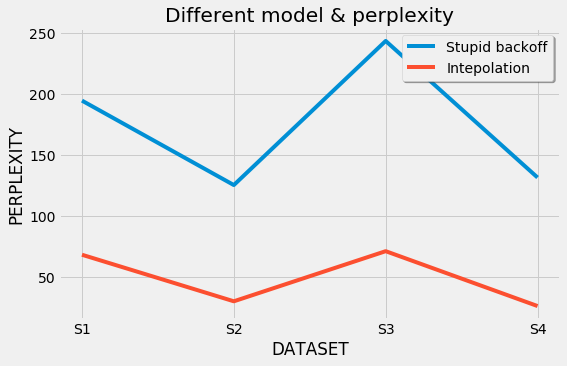

In [89]:
import matplotlib.pyplot as plt

y1 = [br_perp1,gt_perp1,comb_perp_br1,comb_perp_gt1]
y2 = [br_perp,gt_perp,comb_perp_br,comb_perp_gt]
x = ['S1','S2','S3','S4']

plt.figure(figsize=(8,5))
plt.plot(x,y1,label='Stupid backoff')
plt.plot(x,y2,label='Intepolation')
plt.xlabel('DATASET')
plt.ylabel('PERPLEXITY')
plt.title('Different model & perplexity')
legend = plt.legend(loc='upper right', shadow=True)
plt.show()